In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import re
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
import seaborn as sns
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [10]:
def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'im(\d+)\.png', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

def sort_filenames(filenames):
    # Sort the filenames based on the extracted number
    return sorted(filenames, key=extract_number)

class HVM200SequenceDataset(Dataset):
    def __init__(self, image_path, num_timesteps=5, transform=None):
        self.image_path = image_path
        self.num_timesteps = num_timesteps
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) for _ in range(3)]
        for _ in range(self.num_timesteps - 1):
            gray_value = 0.5
            gray_frame = torch.full((3, 224, 224), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return sequence, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

def plot_sequence_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, dataset.num_timesteps + 3 - 1, figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        # sequence, label = dataset[np.random.randint(len(dataset))]
        sequence, label = dataset[i]
        
        for t in range(dataset.num_timesteps + 3 - 1):
            ax = axes[i, t]
            ax.imshow(sequence[t].permute(1, 2, 0))
            ax.axis('off')
            if t == 0:
                ax.set_title(f"Label: {list(dataset.label_to_idx.keys())[list(dataset.label_to_idx.values()).index(label)]}")
    
    plt.tight_layout()
    plt.show()

In [20]:
image_path = "data/hvm200/"

meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
meta_data = pd.read_csv(meta_data_path)
for i in range(len(meta_data)):
    print(f"{i}: {meta_data.iloc[i].values}")

0: ['bear']
1: ['bear']
2: ['bear']
3: ['bear']
4: ['bear']
5: ['bear']
6: ['bear']
7: ['bear']
8: ['bear']
9: ['bear']
10: ['bear']
11: ['bear']
12: ['bear']
13: ['bear']
14: ['bear']
15: ['bear']
16: ['bear']
17: ['bear']
18: ['bear']
19: ['bear']
20: ['elephant']
21: ['elephant']
22: ['elephant']
23: ['elephant']
24: ['elephant']
25: ['elephant']
26: ['elephant']
27: ['elephant']
28: ['elephant']
29: ['elephant']
30: ['elephant']
31: ['elephant']
32: ['elephant']
33: ['elephant']
34: ['elephant']
35: ['elephant']
36: ['elephant']
37: ['elephant']
38: ['elephant']
39: ['elephant']
40: ['person']
41: ['person']
42: ['person']
43: ['person']
44: ['person']
45: ['person']
46: ['person']
47: ['person']
48: ['person']
49: ['person']
50: ['person']
51: ['person']
52: ['person']
53: ['person']
54: ['person']
55: ['person']
56: ['person']
57: ['person']
58: ['person']
59: ['person']
60: ['car']
61: ['car']
62: ['car']
63: ['car']
64: ['car']
65: ['car']
66: ['car']
67: ['car']
68: ['car']
69

In [47]:
meta_data.head()

,object
0,bear
1,bear
2,bear
3,bear
4,bear


Dataset size: 200
Number of classes: 10
Classes: {'bear': 0, 'elephant': 1, 'person': 2, 'car': 3, 'dog': 4, 'apple': 5, 'chair': 6, 'plane': 7, 'bird': 8, 'zebra': 9}


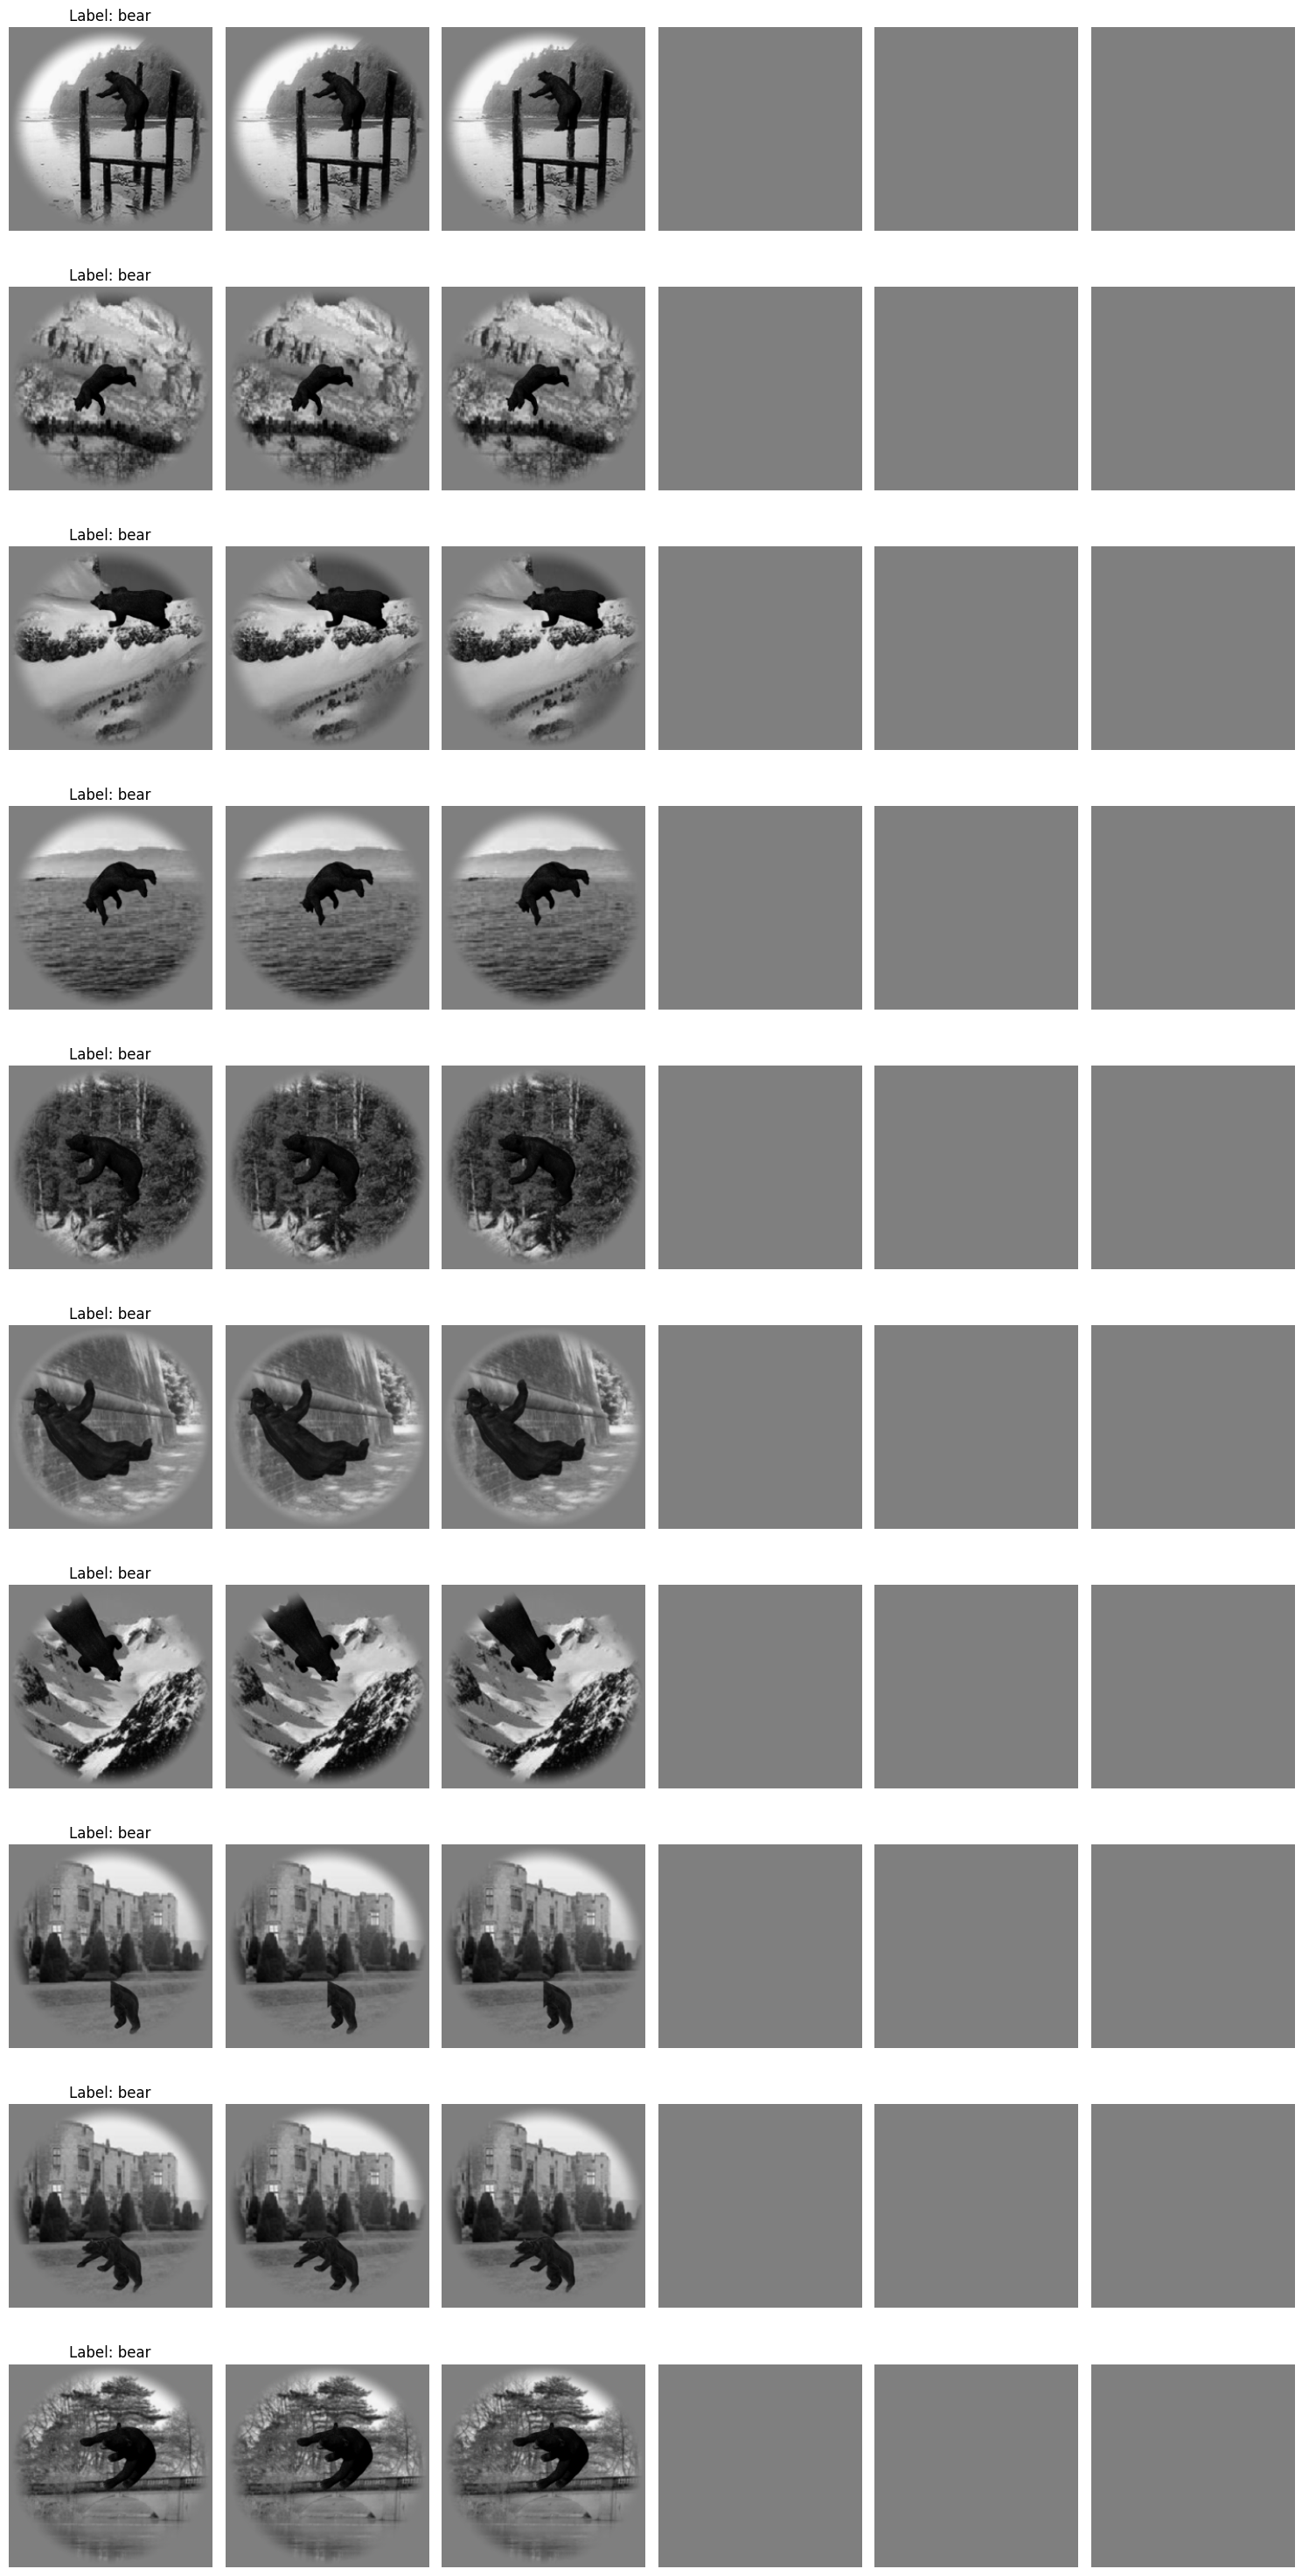

In [11]:
# Usage example:
image_path = "data/hvm200/"

num_timesteps = 4  # 100ms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
# Create the dataset
# dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
#                              img_dir='data/split_dataset/train_coco1600/images_cocogray',
#                              num_timesteps=num_timesteps,
#                              transform=transform)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.label_to_idx)}")
print(f"Classes: {dataset.label_to_idx}")

plot_sequence_samples(dataset, 10)

batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for image, label in loader:
    pass

In [53]:
class Muti1320SequenceDataset(Dataset):
    def __init__(self, image_path, num_timesteps=5, transform=None):
        self.image_path = image_path
        self.num_timesteps = num_timesteps
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) for _ in range(3)]
        for _ in range(self.num_timesteps - 1):
            gray_value = 0.5
            gray_frame = torch.full((3, 224, 224), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return sequence, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

def plot_sequence_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, dataset.num_timesteps + 3 - 1, figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        sequence, label = dataset[np.random.randint(len(dataset))]
        # sequence, label = dataset[i]
        
        for t in range(dataset.num_timesteps + 3 - 1):
            ax = axes[i, t]
            ax.imshow(sequence[t].permute(1, 2, 0))
            ax.axis('off')
            if t == 0:
                ax.set_title(f"Label: {list(dataset.label_to_idx.keys())[list(dataset.label_to_idx.values()).index(label)]}")
    
    plt.tight_layout()
    plt.show()


def create_extended_labels_df():
    # Define the labels and how many instances we want for each
    labels = ['bear', 'elephant', 'person', 'car', 'dog', 'apple', 'chair', 'plane', 'bird', 'zebra']
    instances_per_label = 132
    
    # Create empty lists to store the data
    all_indices = []
    all_labels = []
    
    # Generate the extended dataset
    for label_idx, label in enumerate(labels):
        # Create indices for this label
        start_idx = label_idx * instances_per_label
        indices = list(range(start_idx, start_idx + instances_per_label))
        
        # Add the indices and labels to our lists
        all_indices.extend(indices)
        all_labels.extend([label] * instances_per_label)
    
    # Create the DataFrame
    df = pd.DataFrame({
        # 'index': all_indices,
        'object': all_labels
    })
    
    # Set the index to match the original format
    # df.set_index('index', inplace=True)
    
    return df

In [52]:
extended_df = create_extended_labels_df()
extended_df.value_counts()
extended_df.to_csv("../../data/muri1320/working_memory_images_labels.csv")

Dataset size: 1320


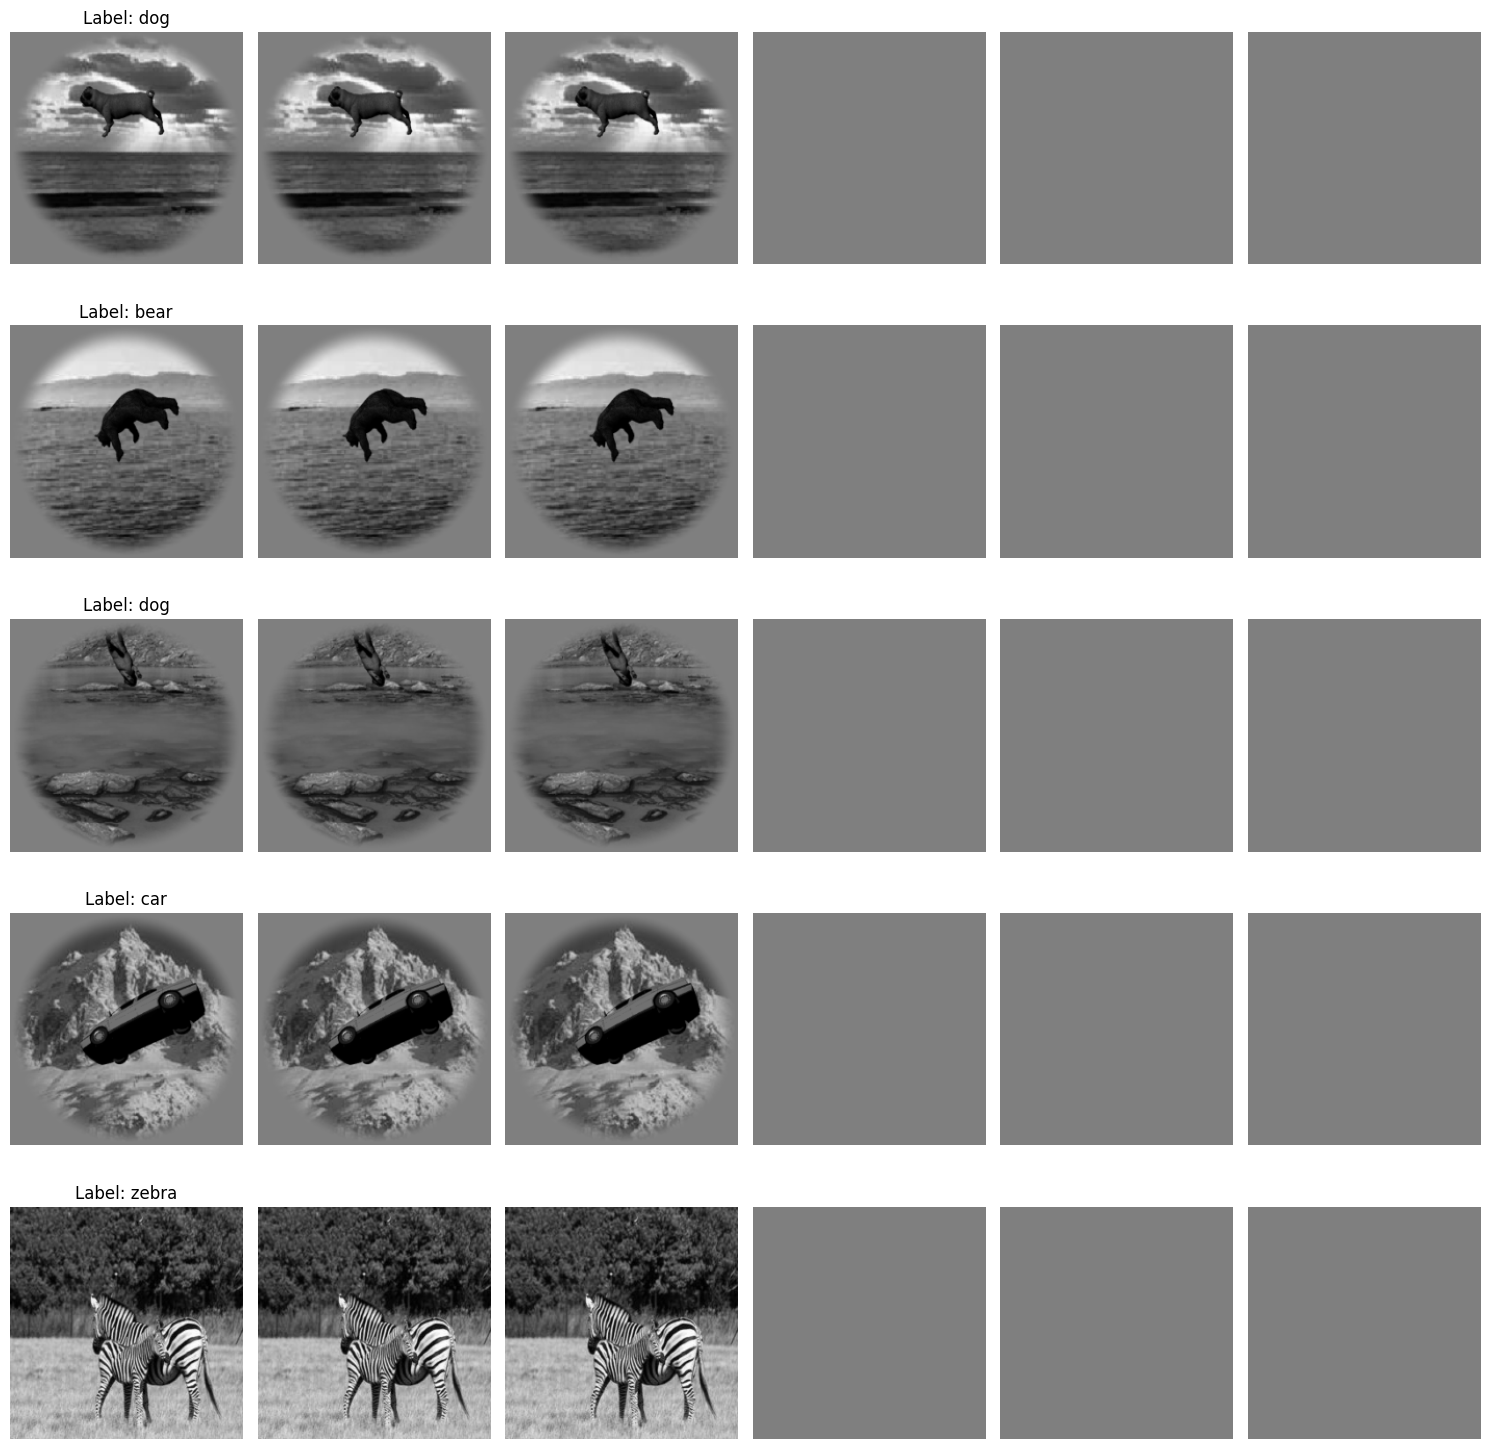

In [54]:
# Usage example:
image_path = "../../data/muri1320/"

num_timesteps = 4  # 100ms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = Muti1320SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)
# Create the dataset
# dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
#                              img_dir='data/split_dataset/train_coco1600/images_cocogray',
#                              num_timesteps=num_timesteps,
#                              transform=transform)

print(f"Dataset size: {len(dataset)}")
# print(f"Number of classes: {len(dataset.label_to_idx)}")
# print(f"Classes: {dataset.label_to_idx}")

plot_sequence_samples(dataset, 5)

batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for image, label in loader:
    pass

# Match indices

In [2]:
import pandas as pd

In [17]:
match_idx_path = "../../data/muri1320/matching_indices.txt"
try:
    with open(match_idx_path, 'r') as file:
        content = file.read()
            # print(line)
except FileNotFoundError:
    print("File not found!")
except IOError:
    print("Error reading file!")

def extract_test_indices(file_content):
    test_indices = []
    
    for line in file_content.split('\n'):
        if line.strip():  # Skip empty lines
            # Extract the number between [ and ,
            number = line.split('[')[1].split(',')[0]
            test_indices.append(int(number))
            
    return test_indices

test_indices = extract_test_indices(content)
print("Test indices:", test_indices)

Test indices: [55, 21, 79, 36, 20, 131, 46, 101, 104, 72, 29, 129, 47, 65, 8, 109, 34, 59, 117, 107, 133, 176, 211, 191, 185, 144, 180, 192, 157, 259, 210, 241, 196, 137, 256, 166, 252, 263, 194, 236, 271, 306, 274, 342, 366, 371, 301, 284, 384, 315, 330, 324, 298, 375, 265, 312, 316, 385, 386, 390, 432, 505, 440, 467, 420, 460, 421, 456, 444, 465, 496, 450, 434, 515, 501, 447, 466, 518, 416, 414, 597, 631, 639, 638, 535, 648, 649, 654, 630, 542, 574, 583, 641, 545, 632, 559, 596, 604, 566, 549, 766, 705, 772, 773, 670, 696, 681, 762, 678, 703, 686, 770, 722, 692, 718, 728, 737, 694, 736, 689, 904, 838, 828, 853, 893, 905, 829, 806, 831, 919, 830, 901, 911, 895, 852, 794, 861, 802, 833, 899, 992, 950, 960, 1032, 1051, 973, 1033, 969, 1036, 988, 924, 958, 1040, 1048, 1049, 989, 1000, 956, 1029, 949, 1085, 1086, 1066, 1104, 1121, 1065, 1177, 1170, 1125, 1183, 1114, 1090, 1175, 1072, 1120, 1170, 1112, 1105, 1162, 1077, 1315, 1233, 1291, 1200, 1217, 1194, 1246, 1248, 1210, 1192, 1257, 1319

In [20]:
match_idx_path = "../../data/muri1320/matching_indices.txt"
try:
    with open(match_idx_path, 'r') as file:
        for line in file:
            line = line.strip()
            print(line)
except FileNotFoundError:
    print("File not found!")
except IOError:
    print("Error reading file!")

im0.png,[55, 'im0055.png']
im1.png,[21, 'im0021.png']
im2.png,[79, 'im0079.png']
im3.png,[36, 'im0036.png']
im4.png,[20, 'im0020.png']
im5.png,[131, 'im0131.png']
im6.png,[46, 'im0046.png']
im7.png,[101, 'im0101.png']
im8.png,[104, 'im0104.png']
im9.png,[72, 'im0072.png']
im10.png,[29, 'im0029.png']
im11.png,[129, 'im0129.png']
im12.png,[47, 'im0047.png']
im13.png,[65, 'im0065.png']
im14.png,[8, 'im0008.png']
im15.png,[109, 'im0109.png']
im16.png,[34, 'im0034.png']
im17.png,[59, 'im0059.png']
im18.png,[117, 'im0117.png']
im19.png,[107, 'im0107.png']
im20.png,[133, 'im0133.png']
im21.png,[176, 'im0176.png']
im22.png,[211, 'im0211.png']
im23.png,[191, 'im0191.png']
im24.png,[185, 'im0185.png']
im25.png,[144, 'im0144.png']
im26.png,[180, 'im0180.png']
im27.png,[192, 'im0192.png']
im28.png,[157, 'im0157.png']
im29.png,[259, 'im0259.png']
im30.png,[210, 'im0210.png']
im31.png,[241, 'im0241.png']
im32.png,[196, 'im0196.png']
im33.png,[137, 'im0137.png']
im34.png,[256, 'im0256.png']
im35.png,